<a href="https://colab.research.google.com/github/sofiapizi/twitter_sentiment/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

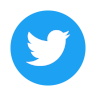

___

# Twitter Sentiment Analysis
___

Università Cattolica del Sacro Cuore

Erica Pirondi 5105752 - Maria Sofia Pizi 5108658 - Fabrizio Niro 5106988

## Project Goal

In this Notebook we introduce classification methods to perform Sentiment Analysis on Twitter data. We follow a Neural Network approach and a Transformer based approach, introducing respectively a LSTM Model and a fine tuned DistilBERT language model.

After training the models on the "Sentiment140" training dataset, we test them on tweets pulled by ourselves from the Twitter API v2 in early December 2022. In particular, we make a Sentiment Analysis on tweets mentioning "Elon Musk".

## Training Dataset Description - Sentiment140
We use the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter API. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.
Sentiment140 was created by Alec Go, Richa Bhayani, and Lei Huang, who were Computer Science graduate students at Stanford University.

### URL
http://help.sentiment140.com/for-students/


In [ ]:
import pandas as pd
import numpy as np
import spacy
import string
import re
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import urllib
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Bidirectional, LSTM, Dropout, SpatialDropout1D
from keras.utils.np_utils import to_categorical
import seaborn as sns
!pip install -q evaluate
!pip install -q datasets
!pip install -q accelerate
import torch
from datasets import load_dataset, Dataset
!pip -q install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/textdiggers

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


     |████████████████████████████████| 81 kB 3.0 MB/s 
     |████████████████████████████████| 452 kB 9.0 MB/s 
     |████████████████████████████████| 132 kB 52.7 MB/s 
     |████████████████████████████████| 182 kB 50.1 MB/s 
     |████████████████████████████████| 212 kB 17.8 MB/s 
     |████████████████████████████████| 127 kB 52.6 MB/s 
     |████████████████████████████████| 191 kB 4.1 MB/s 
     |████████████████████████████████| 5.8 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 75.5 MB/s 
Mounted at /content/drive
/content/drive/MyDrive/textdiggers


# Data Exploratory Analysis

## Data Preparation

The raw dataset Sentiment140 is shown below

In [ ]:
# Read original dataset from .csv file
data = pd.read_csv('data/training_set.csv', encoding='latin-1')
# Set column names
cols = ['label', 'id', 'date', 'query', 'user', 'text']
data.columns = cols
data

,label,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
# Show possible null values
data.isnull().sum()

label    0
id       0
date     0
query    0
user     0
text     0
dtype: int64

In [ ]:
# Count of examples grouped by sentiment
data['label'].value_counts()

4    800000
0    799999
Name: label, dtype: int64

### Preprocess function

We define the function "preprocess" to clean and prepare the raw data provided by Sentiment140. It contains regular expressions as well as lower casing, ASCII filter and null values removal methods. At the end, we add a column containing the characters count for each text, named "text_len". The date is also converted in format Month, Year.

In [ ]:
def preprocess(path: str):

  # Load data from .csv file
  data = pd.read_csv(path, encoding='latin-1')
  cols = ['label', 'id', 'date', 'query', 'user', 'text']
  data.columns = cols
  data = data[['label', 'date', 'text']]

  # Drop NA and empty strings
  data = data.dropna(inplace=False)

  # Change date format
  data['date'] = data['date'].apply(lambda x: x[4:7]+x[-5:])

  # Filter only ASCII characters
  data['text'] = data['text'].apply(lambda x: x.encode("ascii", "ignore").decode())

  # Lower casing text
  data['text'] = data['text'].apply(str.lower)

  # Remove URLs from text
  data['text'] = data['text'].apply(lambda x: re.sub(
      r"http\S+|www\S+|https\S+|([a-z0-9-]+\.)+com|([a-z0-9-]+\.)+org|([a-z0-9-]+\.)+net", "", x, flags=re.MULTILINE))

  # Remove user mentions @ and hashtags # from text
  data['text'] = data['text'].apply(lambda x: re.sub(
      r"\@\w+|\#", "", x))

  # Remove punctuation
  data['text'] = data['text'].apply(lambda x: x.translate(
      str.maketrans('', '', string.punctuation)))

  # Remove blank text
  blanks = []
  for index, label, date, text in data.itertuples():
      if type(text)==str:
          if text.isspace():
              blanks.append(index)
  data.drop(blanks, inplace=True)

  # Remove multiple, leading and trailing spaces
  data['text'] = data['text'].apply(lambda x: re.sub(" +", " ", x))
  data['text'] = data['text'].str.strip()

  # Add column containing length of text
  data['text_len'] = data['text'].apply(lambda x: sum(len(y) for y in x.split()))

  # Convert label from 0-4 to 0-1
  data['label'] = data['label'].replace(4, 1)

  return data

In [ ]:
# Process data by calling the function "preprocess" defined in above chunk
data = preprocess('data/training_set.csv')
data

,label,date,text,text_len
0,0,Apr 2009,is upset that he cant update his facebook by t...,84
1,0,Apr 2009,i dived many times for the ball managed to sav...,60
2,0,Apr 2009,my whole body feels itchy and like its on fire,37
3,0,Apr 2009,no its not behaving at all im mad why am i her...,66
4,0,Apr 2009,not the whole crew,15
...,...,...,...,...
1599994,1,Jun 2009,just woke up having no school is the best feel...,44
1599995,1,Jun 2009,very cool to hear old walt interviews,31
1599996,1,Jun 2009,are you ready for your mojo makeover ask me fo...,45
1599997,1,Jun 2009,happy 38th birthday to my boo of alll time tup...,50


In [ ]:
# Show possible null values
data.isnull().sum()

label       0
date        0
text        0
text_len    0
dtype: int64

In [ ]:
# Count of examples grouped by sentiment
data['label'].value_counts()

0    798329
1    798039
Name: label, dtype: int64

In [ ]:
# Export processed data as .csv file
data.to_csv('data/data_clean.csv', index=False)

In [ ]:
# Read cleaned data from .csv file
data = pd.read_csv('data/data_clean.csv')
# Create dataframe containing only feature needed for model training (text and polarity)
data_ready = data[['text','label']]
# Split train and test sets for huggingface datasets
data_train, data_test = train_test_split(data_ready, test_size = 0.2, random_state = 42)
# Export training and testing datasets to .csv file
data_train.to_csv('data/data_train.csv', index = False)
data_test.to_csv('data/data_test.csv', index = False)

## Data Visualization

In this section we show the main features of the data with some Data Visualization.

In [ ]:
data = pd.read_csv('data/data_clean.csv')

### Donut chart of sentiment distribution

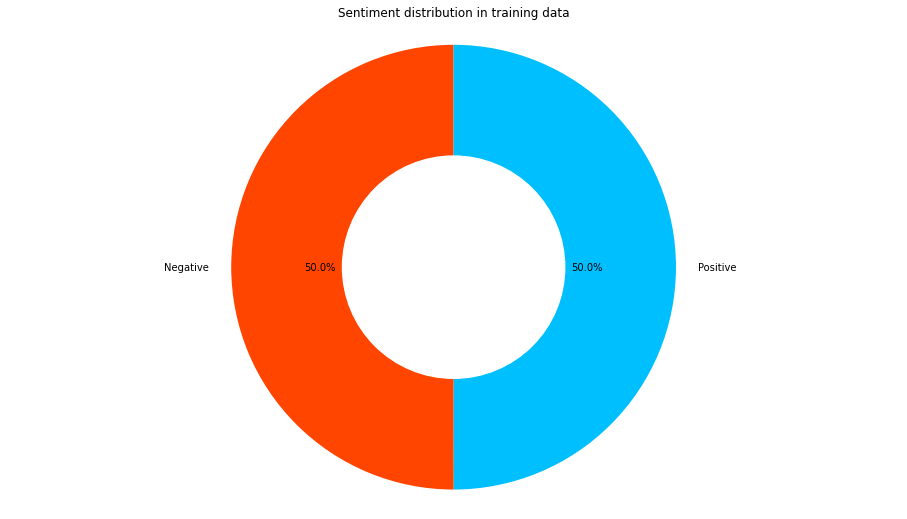

In [ ]:
labels = 'Negative', 'Positive'

sizes = [data[data['label'] == 0]['label'].count(),
         data[data['label'] == 1]['label'].count()]

colors = ['orangered', 'deepskyblue']

plt.figure(figsize=(16,9))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90)

centre_circle = plt.Circle((0,0), 0.5, color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Sentiment distribution in training data')
plt.axis('equal')
plt.show()

### Tweets length

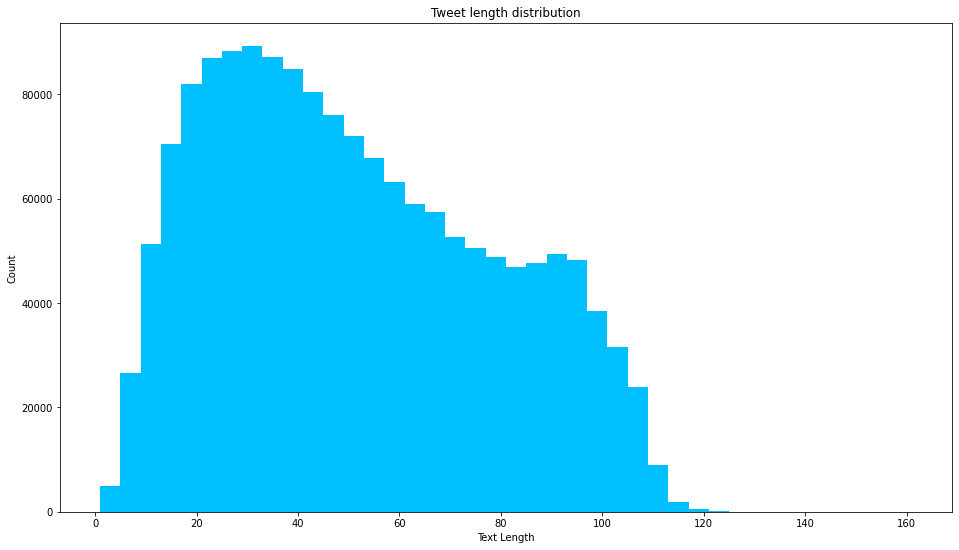

In [ ]:
tweetlen_dist = np.array(data['text_len'])

plt.figure(figsize=(16,9))
plt.hist(tweetlen_dist, 40, color='deepskyblue')

plt.title('Tweet length distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

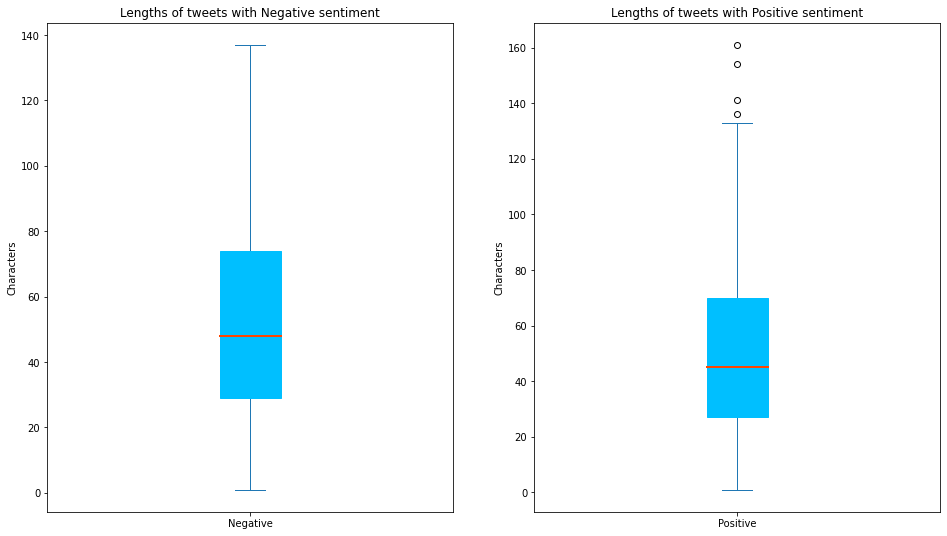

In [ ]:
# Df containing length of tweets with negative sentiment
box_neg = pd.DataFrame({
    'Negative' : data['text_len'][data['label'] == 0]
})
# Df containing length of tweets with positive sentiment
box_pos = pd.DataFrame({
    'Positive' : data['text_len'][data['label'] == 1]
})
# Create figure
boxplot = plt.figure()
ax0 = boxplot.add_subplot(1, 2, 1)
ax1 = boxplot.add_subplot(1, 2, 2)

# Boxplot for Negative sentiment
box_neg.plot(kind='box',
             color={'boxes':'deepskyblue'},
             medianprops={'linestyle': '-', 'linewidth': 2, 'color':'orangered'},
             figsize=(16, 9),
             ax=ax0,
             patch_artist=True)
ax0.set_title('Lengths of tweets with Negative sentiment')
ax0.set_ylabel('Characters')

# Boxplot for Positive sentiment
box_pos.plot(kind='box',
             color={'boxes':'deepskyblue'},
             medianprops={'linestyle': '-', 'linewidth': 2, 'color':'orangered'},
             figsize=(16, 9),
             ax=ax1,
             patch_artist=True)
ax1.set_title('Lengths of tweets with Positive sentiment')
ax1.set_ylabel('Characters')

plt.show()

### Tweets distribution by date

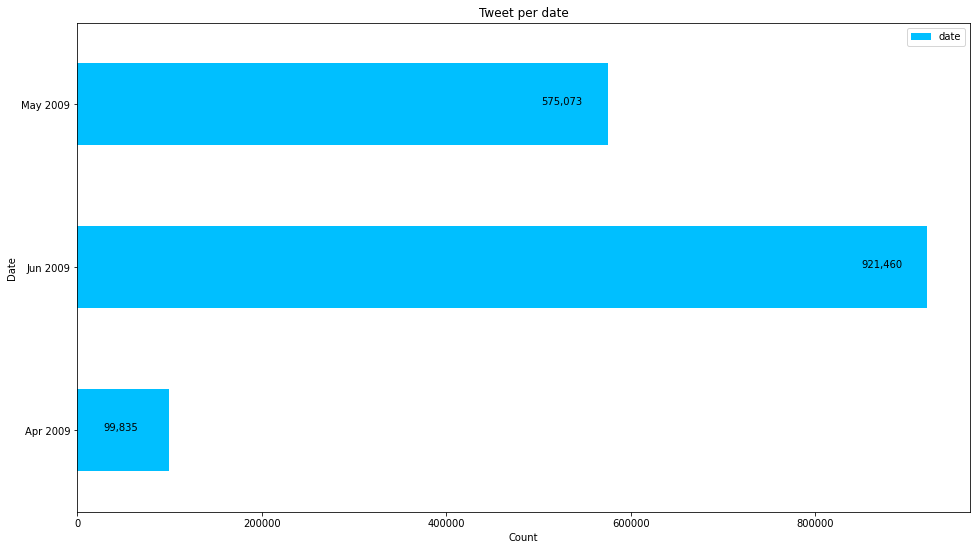

In [ ]:
# tweet distribution according to date
tweet_date = data.groupby('date', axis=0)[['date']].count()
tweet_date.plot(kind='barh', figsize=(16, 9), color='deepskyblue')
plt.title('Tweet per date')
plt.xlabel('Count')
plt.ylabel('Date')

for index, value in enumerate(tweet_date['date']):
    label = format(int(value), ',')

    plt.annotate(label, xy=(value - 72000, index), color='black')

plt.show()

### Wordcloud for Positive Sentiment Tweets

Bigger words are more frequent

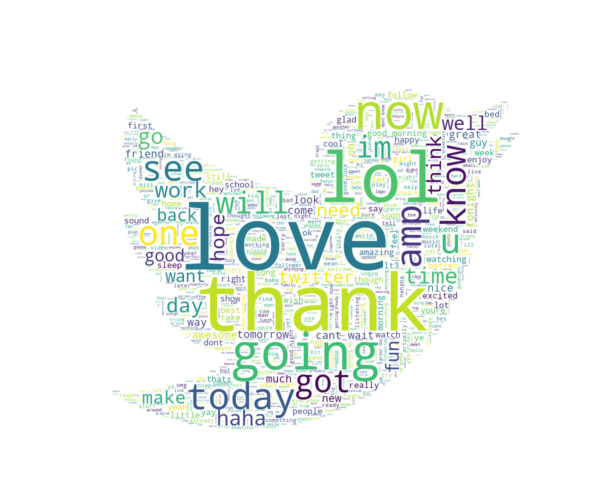

In [ ]:
# Wordcloud for positive sentiment tweets
positive =  data[['text']][data['label'] == 1]

positive.to_csv('wordcloud_plot/positive.txt')

with open('wordcloud_plot/positive.txt',encoding='utf-8') as f:
    positive_tweet = f.read()

#Create set of english stopwords
stopwords = set(STOPWORDS)

# Create the mask
tweet_mask = np.array(Image.open('wordcloud_plot/tweet.jpg'))
# Instantiate a word cloud object
pos_tweet_wc = WordCloud(background_color='white', max_words=2000, mask=tweet_mask, stopwords=stopwords)
# Generate the word cloud
pos_tweet_wc.generate(positive_tweet)
# Display the word cloud
plt.figure(figsize=(16, 9))

plt.imshow(pos_tweet_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Wordcloud for Negative Sentiment Tweets

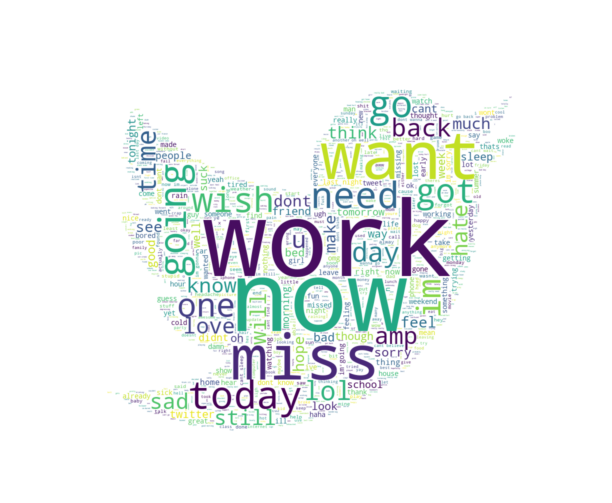

In [ ]:
# Wordcloud for negative sentiment tweets
negative =  data[['text']][data['label'] == 0]

negative.to_csv('wordcloud_plot/negative.txt')

with open('wordcloud_plot/negative.txt',encoding='utf-8') as f:
    negative_tweet = f.read()

# Instantiate a word cloud object
neg_tweet_wc = WordCloud(
    background_color='white',
    max_words=2000,
    mask=tweet_mask,
    stopwords=stopwords
    )
# Generate the word cloud
neg_tweet_wc.generate(negative_tweet)
# Display the word cloud
plt.figure(figsize=(16, 9))

plt.imshow(neg_tweet_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Topic Modelling

In [ ]:
data = pd.read_csv('data/data_clean.csv')

### Negative Matrix Factorization

We use Negative Matrix Factorization to model the most relevant topics found in the corpus.

In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.01, stop_words='english')
dtm = tfidf.fit_transform(data['text'])
nmf_model = NMF(n_components=7,random_state=42)
nmf_model.fit(dtm)

<1596368x73 sparse matrix of type '<class 'numpy.float64'>'
	with 2604470 stored elements in Compressed Sparse Row format>

In [ ]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['oh', 'happy', 'miss', 'haha', 'getting', 'know', 'right', 'really', 'think', 'sad', 'lol', 'gonna', 'going', 'sorry', 'im']


THE TOP 15 WORDS FOR TOPIC #1
['did', 'ive', 'really', 'need', 'oh', 'think', 'twitter', 'amp', 'want', 'know', 'new', 'lol', 'home', 'got', 'just']


THE TOP 15 WORDS FOR TOPIC #2
['know', 'amp', 'sleep', 'home', 'feel', 'oh', 'time', 'thanks', 'lol', 'really', 'hope', 'thats', 'night', 'morning', 'good']


THE TOP 15 WORDS FOR TOPIC #3
['didnt', 'people', 'twitter', 'thats', 'oh', 'haha', 'need', 'think', 'really', 'want', 'feel', 'lol', 'know', 'dont', 'like']


THE TOP 15 WORDS FOR TOPIC #4
['better', 'gonna', 'fun', 'morning', 'sad', 'amp', 'bad', 'school', 'long', 'nice', 'hope', 'tomorrow', 'great', 'happy', 'day']


THE TOP 15 WORDS FOR TOPIC #5
['come', 'happy', 'twitter', 'really', 'watching', 'great', 'oh', 'know', 'haha', 'miss', 'amp', 'lol', 'new', 'thanks', 'love']


THE TOP 15 WORDS FOR TOPIC #6
['bed', 'want', 'ne

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Latent Dirichlet Allocation

Another approach to topic modelling is LDA, here we use it to find the most relevant topics as well

In [ ]:
cv = CountVectorizer(max_df=0.95, min_df=0.01, stop_words='english')
dtm2 = cv.fit_transform(data['text'])
LDA = LatentDirichletAllocation(n_components=7,random_state=42)
LDA.fit(dtm2)

<1596368x73 sparse matrix of type '<class 'numpy.int64'>'
	with 2604470 stored elements in Compressed Sparse Row format>

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['feel', 'great', 'hope', 'working', 'yes', 'happy', 'come', 'better', 'make', 'fun', 'oh', 'thanks', 'night', 'work', 'time']


THE TOP 15 WORDS FOR TOPIC #1
['going', 'good', 'long', 'hope', 'im', 'great', 'work', 'wanna', 'weekend', 'way', 'tomorrow', 'home', 'amp', 'love', 'today']


THE TOP 15 WORDS FOR TOPIC #2
['hope', 'happy', 'work', 'dont', 'hey', 'nice', 'feel', 'sorry', 'right', 'sad', 'im', 'want', 'going', 'good', 'day']


THE TOP 15 WORDS FOR TOPIC #3
['feel', 'thats', 'hope', 'haha', 'thank', 'awesome', 'good', 'great', 'did', 'morning', 'dont', 'know', 'lol', 'like', 'im']


THE TOP 15 WORDS FOR TOPIC #4
['dont', 'going', 'soon', 'school', 'people', 'bed', 'yeah', 'watching', 'ive', 'gonna', 'tonight', 'wish', 'im', 'miss', 'think']


THE TOP 15 WORDS FOR TOPIC #5
['like', 'want', 'work', 'hope', 'little', 'haha', 'getting', 'bad', 'sleep', 'didnt', 'thats', 'ill', 'need', 'really', 'got']


THE TOP 15 WORDS FOR TOPIC #6
['haha', 'work', '

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The results above suggest that there are no evident topics apart from mentions of everyday working routines and feelings.
In addition, there isn't one topic modelling method which outperforms the other. All in all, we can consider LDA groups as more consistent.

Taking into account the LDA method, topic 0,1,3 have a general positive sentiment. For topic 4 and 5 there is a more negative sentiment. Topic 2,6 are ambiguous, but considering some words such as 'day', 'work', 'going', 'hate', 'week' they could regard a general working-day.

# Neural Network Approach

We implement a Neural Network with a LSTM layer and a classification layer with softmax activation function. It has demonstrated to perform fine compared to deeper and more complex configurations.

In [ ]:
# Load clean dataset
data = pd.read_csv('data/data_clean.csv')
data = data[['text', 'label']]
# Max number of features
max_features = 200000
# Tokenizer
tokenizer = Tokenizer(num_words = max_features, split = ' ')
tokenizer.fit_on_texts(data['text'].values)
# Vocabulary size
vocab_size = len(tokenizer.word_counts)
# Vectorize sequences
X = tokenizer.texts_to_sequences(data['text'].values)
# Padding
X = pad_sequences(X)
# One hot encoding Y
Y = pd.get_dummies(data['label']).values
print(f'X shape: {X.shape}  Y shape: {Y.shape}')
print(f'\n\nVocabulary size: {vocab_size}')

X shape: (1596368, 40)  Y shape: (1596368, 2)


Vocabulary size: 436910


In [ ]:
# Split train / test
# Notice that the test set is equivalent for both models
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# Split train / validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [ ]:
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')

X_train shape: (893965, 40), Y_train shape: (893965, 2)


In [ ]:
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

X_test shape: (319274, 40), Y_test shape: (319274, 2)


In [ ]:
print(f'X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}')

X_val shape: (383129, 40), Y_val shape: (383129, 2)


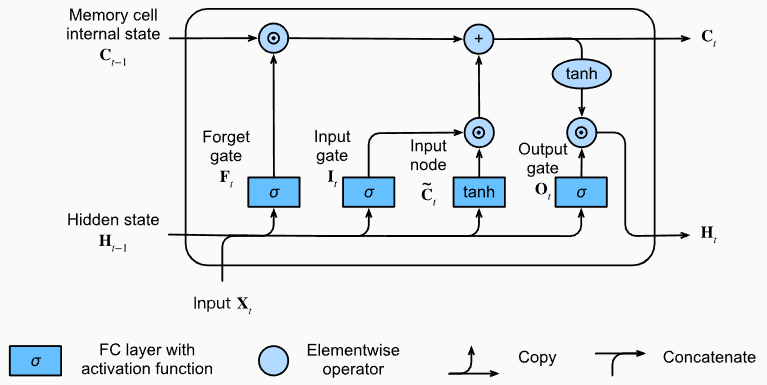

In [ ]:
# Hyperparameters
embed_dim = 512
lstm_out = 512

# Keras Model
model = Sequential(name="LSTM_net")
model.add(Embedding(
    max_features, embed_dim,input_length = X_train.shape[1], name="Embedding"))
model.add(LSTM(lstm_out, dropout=0.1, name = 'LSTM'))
model.add(Dense(2,activation='softmax', name='Softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = 'accuracy')
print(model.summary())

Model: "LSTM_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 40, 512)           102400000 
                                                                 
 LSTM (LSTM)                 (None, 512)               2099200   
                                                                 
 Softmax (Dense)             (None, 2)                 1026      
                                                                 
Total params: 104,500,226
Trainable params: 104,500,226
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 128

# Start training
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, validation_data=[X_val, Y_val], verbose = 1)

Epoch 1/3
6985/6985 [==============================] - 529s 75ms/step - loss: 0.4150 - accuracy: 0.8086 - val_loss: 0.3869 - val_accuracy: 0.8255
Epoch 2/3
6985/6985 [==============================] - 528s 76ms/step - loss: 0.3335 - accuracy: 0.8549 - val_loss: 0.3890 - val_accuracy: 0.8272
Epoch 3/3
6985/6985 [==============================] - 528s 76ms/step - loss: 0.2613 - accuracy: 0.8902 - val_loss: 0.4274 - val_accuracy: 0.8203


In [ ]:
# Save trained model
model.save('lstm_model')

In [ ]:
batch_size = 1024

# Load trained model
model = tf.keras.models.load_model('lstm_model')

In [ ]:
# Make predictions on Test data
predictions = model.predict(X_test)
predictions

with open('data/predictions/lstm_preds', 'wb') as file:
    pickle.dump(predictions, file)

9978/9978 [==============================] - 36s 4ms/step


In [ ]:
with open('data/predictions/lstm_preds', 'rb') as file:
    preds_lstm = pickle.load(file)

preds_lstm_classes = np.argmax(predictions,axis=1)
preds_lstm_classes

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
batch_size = 1024
# Evaluate model on Test data
score, acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("acc: %.2f" % (acc))

312/312 [==============================] - 18s 56ms/step - loss: 0.4314 - accuracy: 0.8182
acc: 0.82


In [ ]:
Y_true =  np.argmax(Y_test, axis=1)

### Confusion Matrix

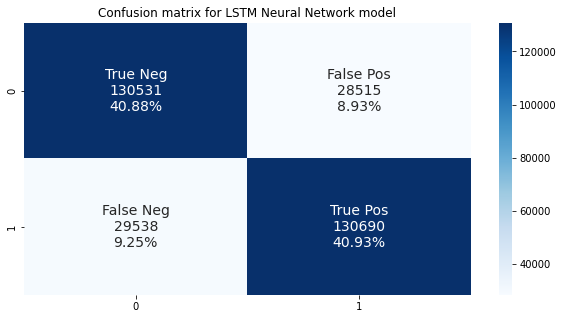

In [ ]:
# Build the confusion matrix
cf_matrix_lstm = confusion_matrix(Y_true,preds_lstm_classes)
# Create labels
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_lstm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_lstm.flatten()/np.sum(cf_matrix_lstm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,5))
palette = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(cf_matrix_lstm,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)
plt.title('Confusion matrix for LSTM Neural Network model')
plt.show()

### Classification report

In [ ]:
cf_rep_lstm = classification_report(Y_true, preds_lstm_classes, target_names = ['Negative', 'Positive'])
print(f'\n Classification report for LSTM Neural Network model: \n\n { cf_rep_lstm }')


 Classification report for LSTM Neural Network model: 

               precision    recall  f1-score   support

    Negative       0.82      0.82      0.82    159046
    Positive       0.82      0.82      0.82    160228

    accuracy                           0.82    319274
   macro avg       0.82      0.82      0.82    319274
weighted avg       0.82      0.82      0.82    319274



# Transformer Based Approach

## Fine Tuned DistilBERT-uncased-base

DistilBERT is a Transformer model, smaller and faster than BERT, which was pretrained on the same corpus in a self-supervised fashion, using the BERT base model as a teacher.

We fine-tune DistilBERT on a relatively small subset of the Sentiment140 dataset. Training it on the whole dataset is an expensive task, but could lead to better results.




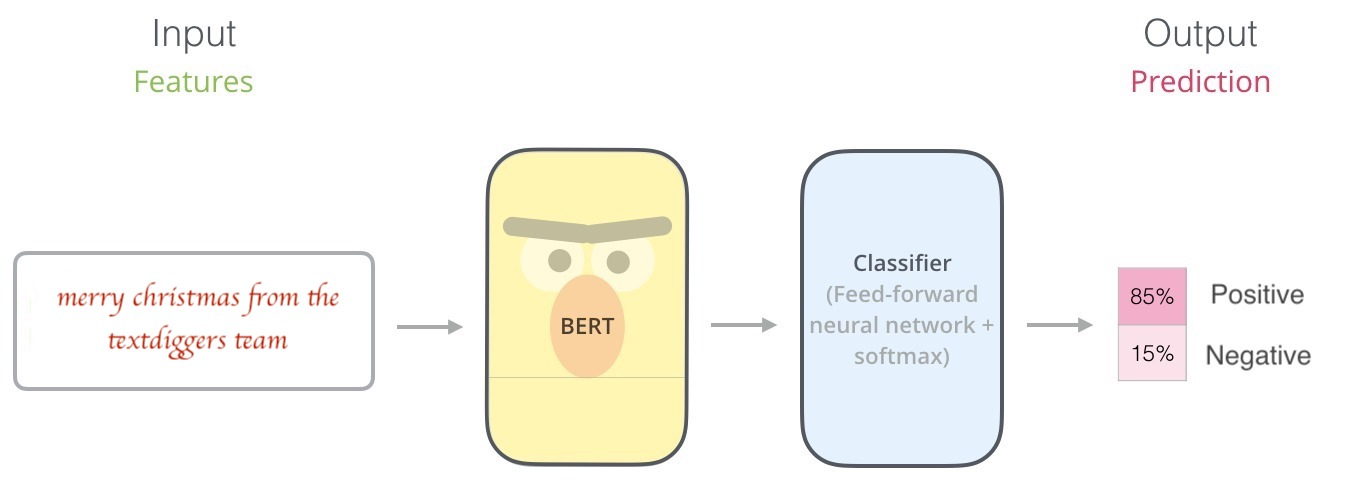

In [ ]:
# Load the data from .csv file using datasets library
dataset = load_dataset('csv', data_files={'train' : 'data/data_train.csv', 'test' : 'data/data_test.csv'})

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset['train'][1000]

{'text': 'how caring of you', 'label': 1}

In [ ]:
dataset['test'][1000]

{'text': 'ouch im trying to tweet more carefully today but it means really delayed responses for the most part',
 'label': 0}

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding = 'max_length', truncation = True)

# Apply tokenizer to data in batches
tokenized_datasets = dataset.map(tokenize_function, batched = True)

  0%|          | 0/320 [00:00<?, ?ba/s]

We select a relatively small subset of 200,000 random examples for training and 10,000 for validation

In [ ]:
# Train data
small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(200000))
# Test data
small_eval_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(10000))

eval_dataset = tokenized_datasets['test']

In [ ]:
# DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
# Metrics for evaluation
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    # Main dir of the model
    output_dir = 'transformers/trainer',
    # Evaluate and save model at each epoch
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    # Keep max 1 checkpoints stored
    save_total_limit = 1,
    load_best_model_at_end = True,
    metric_for_best_model  = 'accuracy',
    auto_find_batch_size = True)

trainer = Trainer(

    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,

)

In [ ]:
# Start training
trainer.train('transformers/trainer/checkpoint-50000')

Loading model from transformers/trainer/checkpoint-50000.
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 200000
  Num Epochs = 3
  Insta

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
3,0.305700,0.658980,0.829200,0.824641,0.839465,0.810331


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to transformers/trainer/checkpoint-75000
Configuration saved in transformers/trainer/checkpoint-75000/config.json
Model weights saved in transformers/trainer/checkpoint-75000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from transformers/trainer/checkpoint-50000 (score: 0.8294).
Deleting older checkpoint [transformers/trainer/checkpoint-75000] due to args.save_total_limit


TrainOutput(global_step=75000, training_loss=0.09826895853678386, metrics={'train_runtime': 9550.4784, 'train_samples_per_second': 62.824, 'train_steps_per_second': 7.853, 'total_flos': 7.94804391936e+16, 'train_loss': 0.09826895853678386, 'epoch': 3.0})

In [ ]:
# Save trained model
trainer.save_model('transformers/model')

Saving model checkpoint to transformers/model
Configuration saved in transformers/model/config.json
Model weights saved in transformers/model/pytorch_model.bin


In [ ]:
# Load trained model
model = AutoModelForSequenceClassification.from_pretrained('transformers/model', num_labels=2)
trainer = Trainer(model = model)

In [ ]:
# Run predictions
predictions = trainer.predict(eval_dataset)

with open('data/predictions/distilbert_preds', 'wb') as file:
    pickle.dump(predictions, file)

In [ ]:
with open('data/predictions/distilbert_preds', 'rb') as file:
    preds_bert = pickle.load(file)

# Transform predictions to labels
preds_bert_classes = preds_bert.predictions.argmax(-1)

Y_true = eval_dataset['label']

### Confusion Matrix

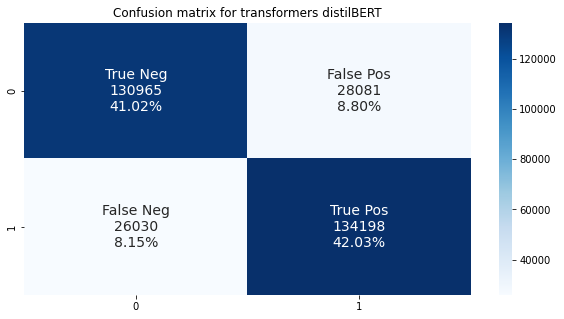

In [ ]:
cf_matrix_trans = confusion_matrix(Y_true,preds_bert_classes)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts_trans = ["{0:0.0f}".format(value) for value in
                cf_matrix_trans.flatten()]
group_percentages_trans = ["{0:.2%}".format(value) for value in
                     cf_matrix_trans.flatten()/np.sum(cf_matrix_trans)]
labels_trans = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts_trans,group_percentages_trans)]

labels_trans = np.asarray(labels_trans).reshape(2,2)
plt.figure(figsize=(10,5))

palette = sns.color_palette("Blues", as_cmap=True)

sns.heatmap(cf_matrix_trans,
            annot=labels_trans,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette)

plt.title('Confusion matrix for transformers distilBERT')
plt.show()

### Classification Report

In [ ]:
cf_rep_trans = classification_report(Y_true, preds_bert_classes, target_names = ['Negative', 'Positive'])
print(f'\n Classification report for transformers distilBERT: \n\n { cf_rep_trans }')


 Classification report for transformers distilBERT: 

               precision    recall  f1-score   support

    Negative       0.83      0.82      0.83    159046
    Positive       0.83      0.84      0.83    160228

    accuracy                           0.83    319274
   macro avg       0.83      0.83      0.83    319274
weighted avg       0.83      0.83      0.83    319274



# Models comparison

In [ ]:
print(f'\n Classification report for LSTM: \n\n { cf_rep_lstm } \n\n')
print(f'\n Classification report for transformers distilBERT: \n\n { cf_rep_trans }')


 Classification report for LSTM: 

               precision    recall  f1-score   support

    Negative       0.82      0.82      0.82    159046
    Positive       0.82      0.82      0.82    160228

    accuracy                           0.82    319274
   macro avg       0.82      0.82      0.82    319274
weighted avg       0.82      0.82      0.82    319274
 



 Classification report for transformers distilBERT: 

               precision    recall  f1-score   support

    Negative       0.83      0.82      0.83    159046
    Positive       0.83      0.84      0.83    160228

    accuracy                           0.83    319274
   macro avg       0.83      0.83      0.83    319274
weighted avg       0.83      0.83      0.83    319274



In the above classification reports we see that there is an average 1% improvement in the metrics of the Transformer model. In particular for the recall metric we can point out that in the neural network we have more predicted false negatives.

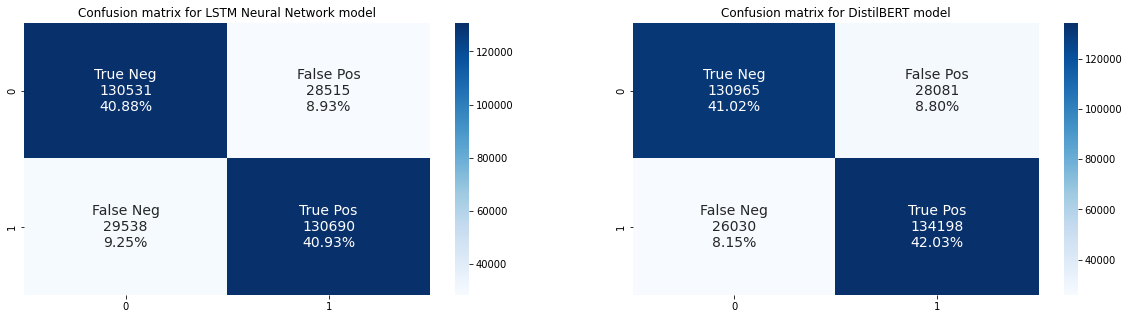

In [ ]:
cf = plt.figure(figsize=(20,5))
ax0 = cf.add_subplot(1, 2, 1)
ax1 = cf.add_subplot(1, 2, 2)
# Build the LSTM confusion matrix
palette = sns.color_palette("Blues", as_cmap=True)
cf_matrix_lstm = confusion_matrix(Y_true,preds_lstm_classes)
sns.heatmap(cf_matrix_lstm,
            annot=labels,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette,
            ax = ax0)
ax0.set_title('Confusion matrix for LSTM Neural Network model')
#Build the Transformers confusion matrix
cf_matrix_trans = confusion_matrix(Y_true,preds_bert_classes)
sns.heatmap(cf_matrix_trans,
            annot=labels_trans,
            fmt='',
            annot_kws={
                'fontsize': 14,
            },
            cmap=palette,
            ax = ax1)
ax1.set_title('Confusion matrix for DistilBERT model')
plt.show()

### Conclusions

From the above results we notice almost comparable performances for the two models. However, we need to address the fact that there is a significant difference in the amount of train data fed to the models, since the transformer approach is way slower than the neural network. Fine tuning the transformer on the same amount of data could probably lead to better results.

# Sentiment of tweets mentioning Elon Musk in December 2022

In this section we show the results of a Sentiment Analysis carried out on tweets in english language pulled from the Twitter API, mentioning the keyword "elonmusk". The tweets belong to a time window of 7 days in early december 2022. The preparation of the data is included in the notebook "musk_dataprep.ipynb".



In [ ]:
data_musk = pd.read_csv('data/tw_musk_clean_text.csv')
data_musk

,text,text_len
0,nobody will ever convince me hes not one of th...,66
1,evidence of one of the biggest political scand...,110
2,christ a lame bastard that was crucified long ...,177
3,merry squidmas from the squidgrowarmy squidgro...,118
4,a pair of rats,11
...,...,...
141187,one of the best things did for canadians was t...,200
141188,ways twitter has changed since took overnn les...,154
141189,indeed,6
141190,this is getting boring release the whole thing...,46


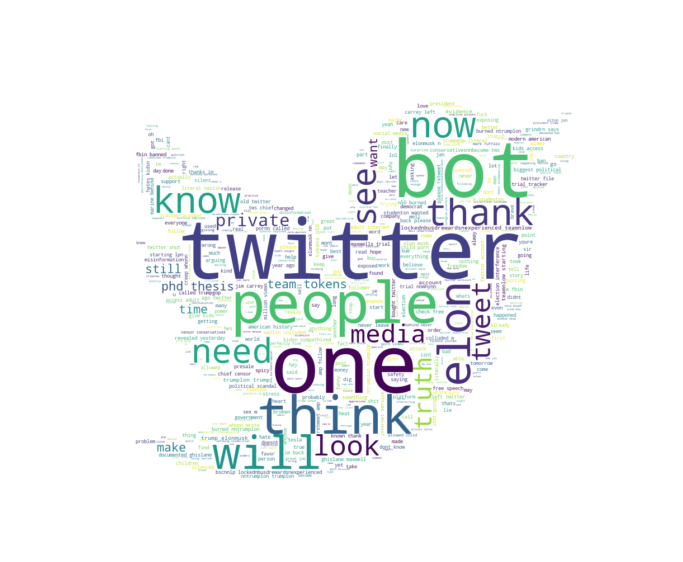

In [ ]:
#tweet_musk = data_musk[['text']]
#tweet_musk.to_csv('wordcloud_plot/tw_musk.txt')

with open('wordcloud_plot/tw_musk.txt', encoding='utf-8') as f:
    tweet_musk = f.read()

tweet_mask = np.array(Image.open('wordcloud_plot/tweet.jpg'))

stopwords = set(STOPWORDS)

# Instantiate a word cloud object
musk_tweet_wc = WordCloud(background_color='white', max_words=2000, mask=tweet_mask, stopwords=stopwords)

# Generate the word cloud
musk_tweet_wc.generate(tweet_musk)

# Display the word cloud
fig = plt.figure(figsize=(12, 16))

plt.imshow(musk_tweet_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Neural Network (LSTM) Approach

In [ ]:
# Max number of features
max_features = 50000
# Tokenizer
tokenizer = Tokenizer(num_words=max_features, split=' ')
# Fit Tokenizer
tokenizer.fit_on_texts(data_musk['text'].values)
vocab_size_musk = len(tokenizer.word_counts)
# Create set of tokenized examples
X_m = tokenizer.texts_to_sequences(data_musk['text'].values)
# Pad sequences
X_m = pad_sequences(X_m, maxlen=40)

X_m.shape

(141192, 40)

In [ ]:
vocab_size_musk

60655

In [ ]:
batch_size = 1024
model = tf.keras.models.load_model('lstm_model')

preds_musk = model.predict(X_m)
preds_musk_classes = np.argmax(preds_musk,axis=1)

with open('data/predictions/musk_lstm_preds', 'wb') as file:
    pickle.dump(preds_musk, file)

4413/4413 [==============================] - 17s 4ms/step


In [ ]:
with open('data/predictions/musk_lstm_preds', 'rb') as file:
    preds_musk = pickle.load(file)

preds_musk_classes = np.argmax(pred_musk,axis=1)

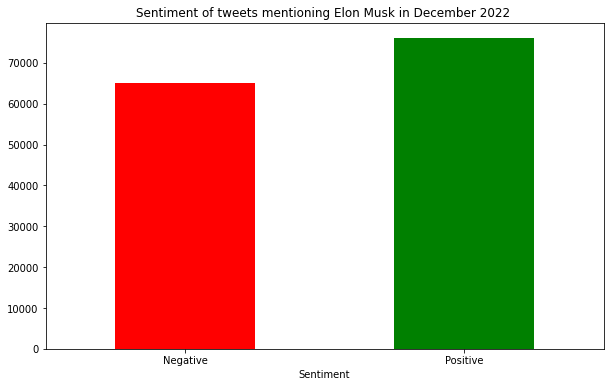

In [ ]:
df_m = pd.DataFrame({
    'Sentiment' : ['Negative', 'Positive'],
    'Count' : [len(pred_musk_classes[pred_musk_classes == 0]),
               len(pred_musk_classes[pred_musk_classes == 1])]
               })

df_m.plot.bar(x='Sentiment',
            y='Count',
            rot=0,
            color={'red':'Negative', 'green':'Positive'},
            legend=False,
            figsize=(10,6)
            )

plt.title('Sentiment of tweets mentioning Elon Musk in December 2022 ')
plt.show()

## Transformers Approach

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('transformers/model')
trainer = Trainer(model = model)

In [ ]:
data_musk = pd.read_csv('data/tw_musk_clean_text.csv')
data_musk_hf = data_musk[['text']]

In [ ]:
dataset_musk = Dataset.from_pandas(data_musk_hf)

In [ ]:
dataset_musk

Dataset({
    features: ['text'],
    num_rows: 141192
})

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding = 'max_length', truncation = True)


tokenized_musk = dataset_musk.map(tokenize_function, batched = True)

  0%|          | 0/142 [00:00<?, ?ba/s]

In [ ]:
pred_musk_bert = trainer.predict(tokenized_musk)

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 141192
  Batch size = 8


In [ ]:
with open('data/predictions/musk_distilbert_preds', 'wb') as file:
    pickle.dump(pred_musk_bert, file)

In [ ]:
with open('data/predictions/musk_distilbert_preds', 'rb') as file:
    pred_musk_bert = pickle.load(file)

# Transform predictions to labels
preds = pred_musk_bert.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(pred_musk_bert[0])/np.exp(pred_musk_bert[0]).sum(-1,keepdims=True)).max(1)

labels = labels.replace({'LABEL_0':'Negative', 'LABEL_1':'Positive'})

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df_m = pd.DataFrame({'text' : dataset_musk['text'],
                     'pred' : preds,
                     'label' : labels,
                     'score' : scores})

df_m.to_csv('data/elonmusk_annotated.csv', index=False)
df_m

,text,pred,label,score
0,nobody will ever convince me hes not one of th...,0,Negative,0.908726
1,evidence of one of the biggest political scand...,0,Negative,0.924908
2,christ a lame bastard that was crucified long ...,1,Positive,0.883842
3,merry squidmas from the squidgrowarmy squidgro...,1,Positive,0.923530
4,a pair of rats,1,Positive,0.690991
...,...,...,...,...
141187,one of the best things did for canadians was t...,1,Positive,0.974114
141188,ways twitter has changed since took overnn les...,0,Negative,0.871874
141189,indeed,1,Positive,0.903052
141190,this is getting boring release the whole thing...,0,Negative,0.951352


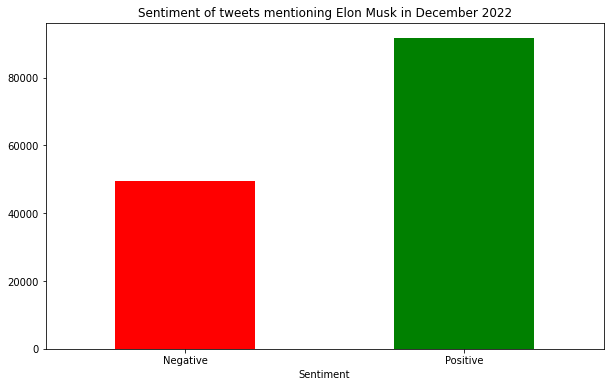

In [ ]:
df_m = pd.DataFrame({
    'Sentiment' : ['Negative', 'Positive'],
    'Count' : [len(preds[preds == 0]),
               len(preds[preds == 1])]
               })

df_m.plot.bar(x='Sentiment',
            y='Count',
            rot=0,
            color={'red':'Negative', 'green':'Positive'},
            legend=False,
            figsize=(10,6)
            )

plt.title('Sentiment of tweets mentioning Elon Musk in December 2022')
plt.show()